Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation

- Do **cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries

- **category_encoders**
- matplotlib
- numpy
- pandas
- **pandas-profiling**
- scikit-learn
- scipy.stats

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Do cross-validation with independent test set

## Overview

### Predict rent in NYC 🏠

We're going back to one of our New York City real estate datasets. 

In [ ]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

# Wrangle train & test sets in the same way
def engineer_features(df):
    
    # Avoid SettingWithCopyWarning
    df = df.copy()
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']
    
    # Extract number of days elapsed in year, and drop original date feature
    df['days'] = (df['created'] - pd.to_datetime('2016-01-01')).dt.days
    df = df.drop(columns='created')

    return df

train = engineer_features(train)
test = engineer_features(test)

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

### Validation options

Let's take another look at [Sebastian Raschka's diagram of model evaluation methods.](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html) So far we've been using "**train/validation/test split**", but we have more options. 

Today we'll learn about "k-fold **cross-validation** with independent test set", for "model selection (**hyperparameter optimization**) and performance estimation."

<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">

<sup>Source: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html</sup>



### Cross-validation: What & Why?

The Scikit-Learn docs show a diagram of how k-fold cross-validation works, and explain the pros & cons of cross-validation versus train/validate/test split.

#### [Scikit-Learn User Guide, 3.1 Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)

> When evaluating different settings (“hyperparameters”) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.
>
> However, **by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.**
>
> **A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV.** 

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

> In the basic approach, called k-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:
>
> - A model is trained using $k-1$ of the folds as training data;
> - the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
>
> The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. **This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set).**

## Follow Along

### cross_val_score

How do we get started? According to the [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics), 

> The simplest way to use cross-validation is to call the [**`cross_val_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) helper function

But, there's a quirk: For scikit-learn's cross-validation [**scoring**](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), higher is better. But for regression error metrics, lower is better. So scikit-learn multiplies regression error metrics by -1 to make them negative. That's why the value of the `scoring` parameter is `'neg_mean_absolute_error'`.

So, k-fold cross-validation with this dataset looks like this:

### Linear Model

In [ ]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

target = 'price'
high_cardinality = ['display_address', 'street_address', 'description']
features = train.columns.drop([target] + high_cardinality)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=20), 
    Ridge(alpha=1.0)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


MAE for 3 folds: [688.76802481 669.12666062 679.61427975]


In [ ]:
-scores.mean()

679.1696550623268

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


MAE for 3 folds: [392.28996182 404.92923235 388.97416404]


In [ ]:
-scores.mean()

395.3977860725861

But the Random Forest has many hyperparameters. We mostly used the defaults, and arbitrarily chose `n_estimators`. Is it too high? Too low? Just right? How do we know?

In [ ]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestregressor'])

Model Hyperparameters:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


## Challenge

You will continue to participate in our Kaggle challenge. Use cross-validation and submit new predictions.

# Use scikit-learn for hyperparameter optimization

## Overview

"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —[Francois Chollet](https://books.google.com/books?id=dadfDwAAQBAJ&pg=PA114)

### Validation Curve

Let's try different parameter values, and visualize "the border between underfitting and overfitting." 

Using scikit-learn, we can make [validation curves](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html), "to determine training and test scores for varying parameter values. This is similar to grid search with one parameter."

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

<sup>Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn</sup>

Validation curves are awesome for learning about overfitting and underfitting. (But less useful in real-world projects, because we usually want to vary more than one parameter.)

For this example, let's see what happens when we vary the depth of a decision tree. (This will be faster than varying the number of estimators in a random forest.)

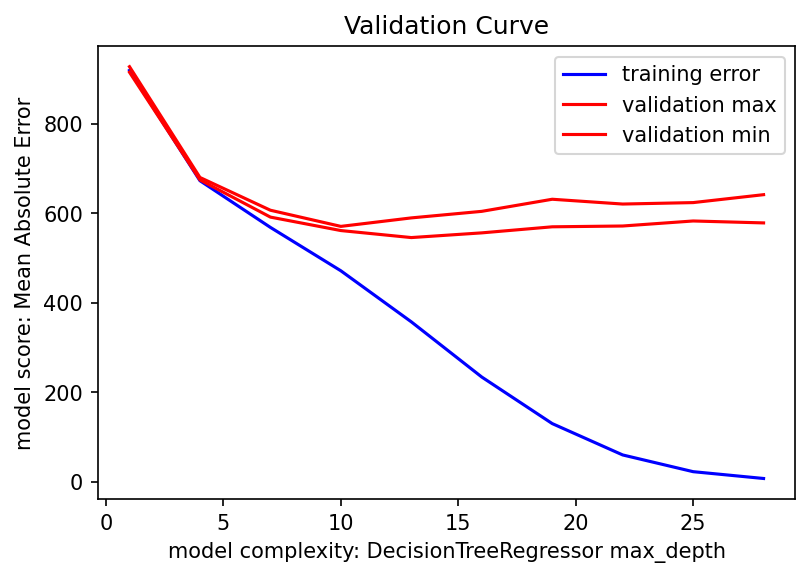

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeRegressor()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_absolute_error', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.max(-val_scores, axis=1), color='red', label='validation max')
plt.plot(depth, np.min(-val_scores, axis=1), color='red', label='validation min')
plt.title('Validation Curve')
plt.xlabel('model complexity: DecisionTreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.legend();

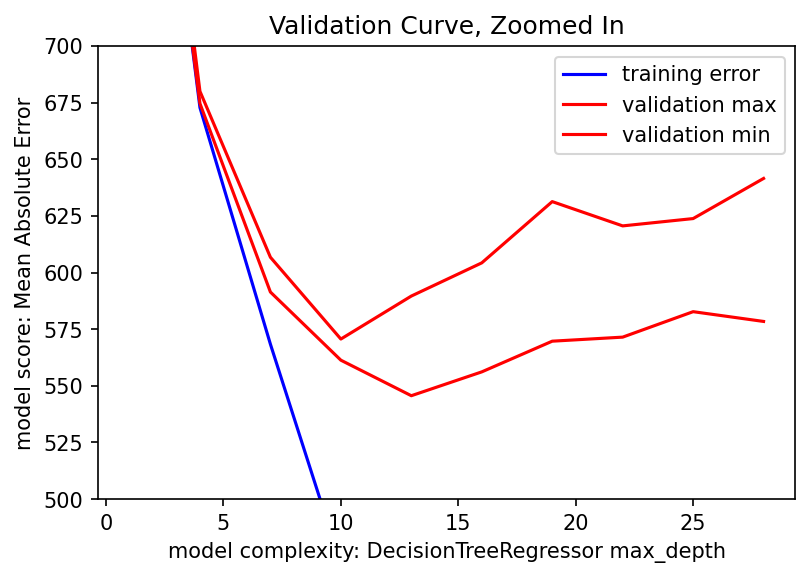

In [ ]:
plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.max(-val_scores, axis=1), color='red', label='validation max')
plt.plot(depth, np.min(-val_scores, axis=1), color='red', label='validation min')
plt.title('Validation Curve, Zoomed In')
plt.xlabel('model complexity: DecisionTreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.ylim((500, 700))  # Zoom in
plt.legend();

## Follow Along

To vary multiple hyperparameters and find their optimal values, let's try **Randomized Search CV.**

#### [Scikit-Learn User Guide, 3.2 Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. 
>
> It is possible and recommended to search the hyper-parameter space for the best cross validation score.
>
> [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) exhaustively considers all parameter combinations, while [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) can sample a given number of candidates from a parameter space with a specified distribution. 
>
> While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.
>
> Specifying how parameters should be sampled is done using a dictionary. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the `n_iter` parameter. 
>
> For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified.

Here's a good blog post to explain more: [**A Comparison of Grid Search and Randomized Search Using Scikit Learn**](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85).

<img src="https://miro.medium.com/max/2500/1*9W1MrRkHi0YFmBoHi9Y2Ow.png" width="50%">

### Linear Model

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

features = train.columns.drop([target] + high_cardinality)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'selectkbest__k': 36, 'ridge__alpha': 10}
Cross-validation MAE 671.929397105717


In [ ]:
# If we used GridSearchCV instead of RandomizedSearchCV, 
# how many candidates would there be?
# 2 imputation strategies * n columns * 3 Ridge alphas
2 * len(X_train.columns) * 3

216

### "Fitting X folds for each of Y candidates, totalling Z fits" ?

What did that mean? What do you think?



### Random Forest

#### [Scikit-Learn User Guide, 3.2 Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

> [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.
>
> For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified.
>
> This example uses the `scipy.stats` module, which contains many useful distributions for sampling parameters.

In [ ]:
from scipy.stats import randint, uniform

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.6min finished
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [2]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

NameError: ignored

### See detailed results

In [ ]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,1,8,3,6,5,4,9,7,0,2
mean_fit_time,45.7792,68.4337,19.9665,45.3997,38.7991,6.26943,17.9882,7.67672,8.97705,2.93621
std_fit_time,0.107856,2.0804,0.118589,0.0216715,0.167704,0.103815,0.127966,0.0943356,0.0490943,0.0110545
mean_score_time,2.68862,1.76287,1.55899,0.966838,0.767083,0.325195,0.339182,1.31603,0.460426,0.475144
std_score_time,0.020658,0.296987,0.060866,0.0736778,0.02522,0.00974667,0.00682975,0.0516844,0.00516391,0.0702723
param_randomforestregressor__max_depth,20,15,None,10,10,10,5,15,5,10
param_randomforestregressor__max_features,0.308902,0.701507,0.256151,0.652565,0.719088,0.371471,0.730736,0.0266693,0.189873,0.00601945
param_randomforestregressor__n_estimators,452,447,209,453,351,89,307,335,447,180
param_simpleimputer__strategy,median,mean,mean,mean,mean,median,median,median,mean,mean
param_targetencoder__min_samples_leaf,241,100,828,158,873,553,842,445,339,296
params,"{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': None, 'ra...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 5, 'rando...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 5, 'rando...","{'randomforestregressor__max_depth': 10, 'rand..."


### Make predictions for test set

In [ ]:
pipeline = search.best_estimator_

In [ ]:
from sklearn.metrics import mean_absolute_error

X_test = test[features]
y_test = test[target]

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $433



Here's what the [`RandomizdSearchCV` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) says about the `best_estimator_` attribute:

> **best_estimator_** : ***estimator***  
> Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if `refit=False`. ... See `refit` parameter for more information ...

So let's look at the `refit` parameter too:

> **refit** : ***boolean, string, or callable, default=True***  
> Refit an estimator using the best found parameters on the whole dataset.

By default, scikit-learn cross-validation will _"refit an estimator using the best found parameters on the whole dataset",_ which means, use **all** the training data:

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="50%">

***Tip: If you're doing 3-way train/validation/test split, you should do this too!*** After you've optimized your hyperparameters and selected your final model, then manually refit on both the training and validation data.

## Challenge

For your assignment, use scikit-learn for hyperparameter optimization with RandomizedSearchCV.

# Review

Continue to participate in our Kaggle Challenge, and practice these objectives:

- Do **cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

You can refer to these suggestions when you do hyperparameter optimization, now and in future projects:

### Tree Ensemble hyperparameter suggestions

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)

#### XGBoost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low, can try increasing)
- n_estimators (too low underfits, too high wastes time/overfits) — _I recommend using early stopping instead of cross-validation_
- learning_rate (too low underfits, too high overfits)
- See [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) for more ideas

### Linear Model hyperparameter suggestions 

#### Logistic Regression
- C
- class_weight (for imbalanced classes)
- penalty

#### Ridge / Lasso Regression
- alpha

#### ElasticNet Regression
- alpha
- l1_ratio

For more explanation, see [**Aaron Gallant's 9 minute video on Ridge Regression**](https://www.youtube.com/watch?v=XK5jkedy17w)!

# Sources
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3,](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html) Hyperparameters and Model Validation
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)
- Ron Zacharski, [A Programmer’s Guide to Data Mining, Chapter 5,](http://guidetodatamining.com/chapter5/) first 10 pages, for a great explanation of cross-validation with examples and pictures
- Sebastian Raschka, [Model Evaluation](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html)
- [Scikit-Learn User Guide, 3.1 Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Scikit-Learn User Guide, 3.2 Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
- [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
- [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- [xgboost, Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)